# Neural Nested Network (NNN) for Marketing Mix Modeling



This notebook demonstrates the implementation of the **Neural Nested Network (NNN)** as proposed in the 2024 paper [*Neural Nested Networks for Unified Marketing Mix Modeling*](https://arxiv.org/abs/2504.06212). NNN is a Transformer-based model for learning advertising effects with both direct and indirect pathways (e.g., media → search → conversion). It supports interpretable multi-task modeling of **sales and intermediate KPIs like branded search volume**, all in an end-to-end neural framework.

## 📘 Paper Summary

- Models both **direct media → sales** and **indirect media → search → sales** paths using a nested architecture.
- Uses **factored self-attention** to separately capture time and channel effects.
- Learns both **sales and search** outputs with residual path weighting to model their interaction.
- Enables flexible input design (e.g., embeddings for creative features, seasonality, external signals).
- Unlike Bayesian MMM approaches, NNN allows for **transfer learning**, **non-additive synergies**, and rich **feature embeddings**.



# Prerequisites

## 🚀 Installation

1\. Make sure you are using one of the available GPU Colab runtimes which is **required** to run Meridian.

In [1]:
# Import packages
import copy
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

## 🔧 Constants and Hyperparameters

We define simulation constants (e.g., geo count, time steps) and model hyperparameters in one place for easier tuning and reproducibility.


In [2]:
# Set seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

In [3]:
# Simulation Constants
N_GEOS = 47
TIME_STEPS = 104  # Number of weeks (2 years)
MEDIA_CHANNELS = ["TVCM", "YouTube", "Taxi", "Display"]
NUM_CHANNELS = len(MEDIA_CHANNELS)
EMBED_DIM = 256

In [4]:
# Model Hyperparameters
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_EPOCHS = 500
BATCH_SIZE = 8
ALPHA = 0.5
L1_LAMBDA = 1e-5
GRAD_NOISE_STD = 1e-5
MAX_GRAD_NORM = float("inf")
N_HEADS = 4
N_LAYERS = 2
DROPOUT = 0.1
HIDDEN_CHANNELS = 64
LOOKBACK_WINDOW = 52
LEARNING_RATE = 0.001

## 🏗 Synthetic Data Generation

We simulate a 2-year, 47-region media dataset with weekly ad spend across 4 channels, organic search trends, and sales outcomes.  
The simulation follows the structure from the NNN paper and includes:
- Creative effectiveness embeddings
- Seasonality patterns in search
- Adstock and Hill transformations
- Direct and indirect contributions from media to outcomes

Finally, we aggregate this into a structured pandas DataFrame for preview and analysis.


In [5]:
# Creative Effectiveness Embeddings
min_factor, max_factor = 0.5, 1.5
intent_factors = np.random.uniform(min_factor, max_factor, size=TIME_STEPS)
low_embed = np.random.normal(size=EMBED_DIM)
high_embed = np.random.normal(size=EMBED_DIM)
creative_embeddings = np.stack(
    [low_embed + ((f - min_factor) / (max_factor - min_factor)) * high_embed for f in intent_factors]
)

# Organic Search Baseline
weeks = np.arange(TIME_STEPS)
geo_base_levels = np.random.uniform(60, 140, size=N_GEOS)
seasonal = 1 + 0.1 * np.sin(2 * np.pi * weeks / 52)
baseline_search = np.zeros((N_GEOS, TIME_STEPS))
for i in range(N_GEOS):
    baseline = geo_base_levels[i] * seasonal
    noise = np.random.normal(scale=0.02 * geo_base_levels[i], size=TIME_STEPS)
    baseline_search[i] = np.clip(baseline + noise, 0, None)

# Media Spend Simulation
media_spend = np.zeros((N_GEOS, TIME_STEPS, NUM_CHANNELS))
for i in range(N_GEOS):
    for j in range(NUM_CHANNELS):
        base_spend = geo_base_levels[i] * 0.1
        spend = np.random.gamma(2.0, base_spend / 2.0, size=TIME_STEPS)
        spend = np.convolve(spend, [0.5, 1.0, 0.5], mode="same")
        spend = np.clip(spend * (base_spend / (spend.mean() + 1e-9)), 0, None)
        media_spend[i, :, j] = spend


# Adstock Function
def adstock_transform(x, retention=0.5):
    y, carry = np.zeros_like(x), 0.0
    for t in range(len(x)):
        carry = x[t] + retention * carry
        y[t] = carry
    return y


# Hill Function
def hill_transform(x, half_sat=1.0, slope=1.0):
    return np.power(x, slope) / (np.power(x, slope) + np.power(half_sat, slope))


# Effect Parameters & Sales Generation
conv_rate = 0.001
params = {
    "TVCM_direct": {"retention": 0.8, "half_sat": 100.0},
    "TVCM_indirect": {"retention": 0.5, "half_sat": 80.0},
    "YouTube_direct": {"retention": 0.6, "half_sat": 50.0},
    "YouTube_indirect": {"retention": 0.3, "half_sat": 40.0},
    "Taxi_direct": {"retention": 0.5, "half_sat": 50.0},
    "Taxi_indirect": {"retention": 0.4, "half_sat": 40.0},
    "Display_direct": {"retention": 0.3, "half_sat": 20.0},
}
sales_weights = {"TVCM_direct": 3.0, "YouTube_direct": 3.0, "Taxi_direct": 1.0, "Display_direct": 1.0}

sales = np.zeros((N_GEOS, TIME_STEPS))
total_search = np.zeros((N_GEOS, TIME_STEPS))
direct_contribs = np.zeros((N_GEOS, TIME_STEPS))
for i in range(N_GEOS):
    search_add_total = np.zeros(TIME_STEPS)
    for ch in ["TVCM", "YouTube", "Taxi"]:
        ad = adstock_transform(media_spend[i, :, MEDIA_CHANNELS.index(ch)], retention=params[f"{ch}_indirect"]["retention"])
        sat = hill_transform(ad, params[f"{ch}_indirect"]["half_sat"])
        scale = 0.2 * baseline_search[i].mean() / (sat.mean() + 1e-9)
        search_add_total += scale * sat * intent_factors

    total_search[i] = np.clip(baseline_search[i] + search_add_total, 0, None)
    contrib = np.zeros(TIME_STEPS)
    for ch in MEDIA_CHANNELS:
        ad = adstock_transform(media_spend[i, :, MEDIA_CHANNELS.index(ch)], retention=params[f"{ch}_direct"]["retention"])
        sat = hill_transform(ad, params[f"{ch}_direct"]["half_sat"])
        contrib += sales_weights.get(f"{ch}_direct", 0) * sat * intent_factors
    direct_contribs[i] = contrib

for i in range(N_GEOS):
    sales_from_search = conv_rate * total_search[i] * intent_factors
    sales[i] = sales_from_search + direct_contribs[i]
    sales[i] += np.random.normal(scale=0.01 * sales[i].mean(), size=TIME_STEPS)
    sales[i] = np.clip(sales[i], 0, None)

# Create pandas DataFrame
records = []
for i in range(N_GEOS):
    for t in range(TIME_STEPS):
        row = {"geo": i, "week": t, "sales": sales[i, t], "search": total_search[i, t]}
        row.update({f"spend_{ch.lower()}": media_spend[i, t, MEDIA_CHANNELS.index(ch)] for ch in MEDIA_CHANNELS})
        records.append(row)
df = pd.DataFrame(records)
df.head()

,geo,week,sales,search,spend_tvcm,spend_youtube,spend_taxi,spend_display
0,0,0,1.011406,150.393092,6.002040,7.986910,3.047964,10.154394
1,0,1,2.587041,186.552853,6.232331,10.879736,6.052360,14.102399
2,0,2,2.664998,181.612925,6.598455,11.299594,4.633684,14.139109
3,0,3,2.518752,182.375744,8.895844,11.191355,4.885314,13.378523
4,0,4,1.661355,169.628955,15.090986,9.759477,7.879934,14.115923


# Better Creative Simulation


- First Identify the weeks that have Good sales
- Ask AI to create 13 creative piece and rank them from the best to worst
- For weeks with high sales you allocate it to the good creative pieces and the other way around
- Convert them to embeddings either using BERT or by tokenisation (if we want it to be trained faster) - Note that BERT takes Longer but tokenisation might overwhelm the number of parameters to be trained ( you can fix them for the first n epochs )
- Normalise to bring mean to zero and std to 1

In [6]:
import pandas as pd
import pprint

# ─── 1. Rebuild weekly_sales if needed ─────────────────────────────────────────
weekly_sales = (
    df.groupby("week", as_index=False)["sales"]
      .sum()
      .rename(columns={"sales": "total_sales"})
)
weekly_sales["rank"] = (
    weekly_sales["total_sales"]
      .rank(method="first", ascending=False)
      .astype(int)
)
weekly_sales.sort_values("week", inplace=True)

# ─── 2. Define 13 creatives from strongest to weakest ──────────────────────────
creative_variations = [
    "Demand is sky-high—unlock Apple’s deepest 30% discount on our flagship devices. Your future self will thank you.",
    "Spark your creativity with our iPad + Apple Pencil bundle at 25% off. Draw, note, innovate this week only.",
    "Shine in every click—get 20% off the new iPhone camera upgrades and capture life’s brightest moments.",
    "Stay powered in style with 15% off MacBook Air and free engraving. Personalize your productivity now.",
    "Go green with Apple’s refurbished lineup at 12% off. Great tech, smaller footprint—sustainable choice.",
    "Flash feature week—18% off HomePod mini. Pump up your home soundscape.",
    "Bold moves—get 22% off select accessories and stand out from the crowd with style.",
    "Insider perk—access early-release bundles and snag a 20% discount before anyone else.",
    "Apple at your service—free shipping plus 12% bonus credit on Apple TV purchases this week.",
    "Ready for takeoff? 10% off Apple Watch SE to track your fitness journey. Limited-time offer.",
    "Light-touch deal—take 7% off across all devices as our token of appreciation.",
    "Vanilla vibes—our top sellers at regular price. Straightforward choice, pure Apple experience.",
    "Standard showcase—discover the latest Apple gear at everyday pricing with no frills and no discount."
]

# ─── 3. Bin weeks by rank into 13 equal groups ─────────────────────────────────
group_size = len(weekly_sales) // len(creative_variations)  # 104 // 13 = 8
weekly_sales["variation_idx"] = (
    ((weekly_sales["rank"] - 1) // group_size)
    .clip(upper=len(creative_variations) - 1)
    .astype(int)
)

# ─── 4. Map each week to its creative message ──────────────────────────────────
weekly_sales["creative_message"] = weekly_sales["variation_idx"] \
    .apply(lambda i: creative_variations[i])

# ─── 5. Print the final list of 104 messages in week order ────────────────────
messages = weekly_sales.sort_values("week")["creative_message"].tolist()

print("messages:\n")
pprint.pprint(messages, width=100)


# ___ Best and Worst sales week (hence creative) to be used in future simulations _________
id_best  = int(weekly_sales.loc[weekly_sales["rank"] == 1, "week"].item())
id_worst = int(weekly_sales.loc[weekly_sales["rank"] == weekly_sales["rank"].max(), "week"].item())


messages:

['Standard showcase—discover the latest Apple gear at everyday pricing with no frills and no '
 'discount.',
 'Bold moves—get 22% off select accessories and stand out from the crowd with style.',
 'Bold moves—get 22% off select accessories and stand out from the crowd with style.',
 'Bold moves—get 22% off select accessories and stand out from the crowd with style.',
 'Vanilla vibes—our top sellers at regular price. Straightforward choice, pure Apple experience.',
 'Light-touch deal—take 7% off across all devices as our token of appreciation.',
 'Standard showcase—discover the latest Apple gear at everyday pricing with no frills and no '
 'discount.',
 'Spark your creativity with our iPad + Apple Pencil bundle at 25% off. Draw, note, innovate this '
 'week only.',
 'Go green with Apple’s refurbished lineup at 12% off. Great tech, smaller footprint—sustainable '
 'choice.',
 'Stay powered in style with 15% off MacBook Air and free engraving. Personalize your productivity '
 '

In [7]:
#USING BERT TO CREATE EMBEDDINGS ON THE CREATIVE PIECES
import numpy as np
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel

# ─── 1) Settings ───────────────────────────────────────────────
sequence_length = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ─── 2) Load pretrained BERT + small projector ────────────────
tokenizer   = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model  = BertModel.from_pretrained('bert-base-uncased').to(device).eval()
layer_norm  = nn.LayerNorm(bert_model.config.hidden_size).to(device)
project256  = nn.Linear(bert_model.config.hidden_size, 256).to(device)

# ─── 3) Helper to get a batch of CLS→256 embeddings ────────────
def _embed_batch(texts: list[str]) -> np.ndarray:
    enc = tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=sequence_length,
        return_tensors='pt'
    ).to(device)
    with torch.no_grad():
        out      = bert_model(**enc)
        cls_vec  = out.last_hidden_state[:,0,:]        # (N,768)
        normed   = layer_norm(cls_vec)                # (N,768)
        emb256   = project256(normed)                  # (N,256)
    return emb256.cpu().numpy()

# ─── 4) Compute global mean/std on your original 104 messages ───
all_raw     = _embed_batch(messages)                  # shape (104,256)
global_mean = all_raw.mean(axis=0, keepdims=True)     # (1,256)
global_std  = all_raw.std(axis=0, keepdims=True) + 1e-6

# ─── 5) Define your new tokeniser using BERT + global scaler ─
def tokeniser(texts: list[str]) -> np.ndarray:
    """
    texts: list of strings
    returns: (len(texts), 256)-array of normalized embeddings
    """
    emb_raw = _embed_batch(texts)                     # (n,256)
    return (emb_raw - global_mean) / global_std       # normalize per-dimension

# ─── 6) Initial creative embeddings for training ───────────────
creative_embeddings = tokeniser(messages)             # (104,256)
print(creative_embeddings.shape)                      # → (104, 256)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

(104, 256)


In [8]:
# USING TOKENISER TO BUILD EMBEDDINGS BUT HAS QUALITY ISSUE DUE TO SMALL VECTOR SPACE
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.layers import TextVectorization, Embedding, GlobalAveragePooling1D
# from tensorflow.keras import Sequential

# # --- 1) Parameters ---
# vocab_size      = 5000
# sequence_length = 50
# embedding_dim   = 256

# # --- 2) Build & Adapt the pipeline on your full corpus ---
# vectorizer = TextVectorization(
#     max_tokens=vocab_size,
#     output_mode="int",
#     output_sequence_length=sequence_length
# )
# embed_model = Sequential([
#     vectorizer,
#     Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=True),
#     GlobalAveragePooling1D()
# ])
# vectorizer.adapt(messages)

# # --- 3) Compute global mean & std over all 104 originals ---
# all_raw = embed_model.predict(tf.constant(messages), verbose=0)  # (104,256)
# global_mean = np.mean(all_raw, axis=0, keepdims=True)           # (1,256)
# global_std  = np.std(all_raw, axis=0, keepdims=True) + 1e-6     # (1,256)

# # --- 4) Define tokeniser that uses the *same* pipeline + global scaler ---
# def tokeniser(texts: list[str]) -> np.ndarray:
#     """
#     texts: list of strings to embed
#     returns: (len(texts), 256) embeddings normalized by global mean/std
#     """
#     emb_raw = embed_model.predict(tf.constant(texts), verbose=0)    # (n,256)
#     return (emb_raw - global_mean) / global_std                    # (n,256)

# # --- 5) Get your initial creative_embeddings for the model training ---
# creative_embeddings = tokeniser(messages)  # shape (104,256)
# print(creative_embeddings.shape)           # → (104, 256)


# 🧠 Model: Neural Nested Network (NNN)



We now define the **Neural Nested Network (NNN)** architecture, a Transformer-based sequence model designed to:

- Learn both direct (`media → sales`) and indirect (`media → search → sales`) effects.
- Encode rich multi-channel media signals over time using **factored self-attention**.
- Predict both **sales** and **search** outputs, with optional disentangled training.
- Support weekly temporal embeddings and multiple Transformer layers.

### 🔍 Key Enhancements Beyond the Original Paper

| Feature | Description |
|--------|-------------|
| **Stacked Attention Layers** | We use multiple layers (`n_layers`) of attention + MLP to deepen modeling capacity. |
| **Residual Path Weights** | We learn soft residual weights to balance direct vs. search-driven sales paths. |
| **Denormalized Output Layer** | Geo-specific affine transformation restores outputs to natural scale. |

The model remains interpretable and modular, and can be extended with creative embeddings, keyword trends (e.g., SLaM), or brand awareness inputs.


In [9]:
class NNNModel(nn.Module):
    def __init__(
        self,
        n_channels,
        embed_dim,
        n_heads=N_HEADS,
        lookback_window=LOOKBACK_WINDOW,
        hidden_channels=HIDDEN_CHANNELS,
        n_layers=N_LAYERS,
        dropout=DROPOUT,
        n_geos=N_GEOS,
        time_steps=TIME_STEPS,
        use_geo=True,
        channel_mixing=True,
        attention_by_channel=True,
    ):
        super().__init__()
        self.n_channels = n_channels
        self.embed_dim = embed_dim
        self.n_layers = n_layers
        self.use_geo = use_geo
        self.channel_mixing = channel_mixing
        self.attention_by_channel = attention_by_channel

        if attention_by_channel:
            self.time_attn_layers = nn.ModuleList(
                [nn.MultiheadAttention(embed_dim, n_heads, batch_first=True) for _ in range(n_layers)]
            )
        else:
            self.time_attn_layers = nn.ModuleList(
                [nn.MultiheadAttention(n_channels * embed_dim, n_heads, batch_first=True) for _ in range(n_layers)]
            )

        self.dropout = nn.Dropout(dropout)  # dropout for residual connections

        self.channel_fc1_layers = nn.ModuleList([nn.Linear(n_channels, hidden_channels) for _ in range(n_layers)])
        self.channel_fc2_layers = nn.ModuleList([nn.Linear(hidden_channels, hidden_channels) for _ in range(n_layers)])
        self.channel_fc3_layers = nn.ModuleList([nn.Linear(hidden_channels, n_channels) for _ in range(n_layers)])

        # —SalesHead § 15.9—
        self.head_sales = nn.Sequential(
            nn.Linear(n_channels * embed_dim, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, 1),
        )
        self.head_search = nn.Sequential(
            nn.Linear(n_channels * embed_dim, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, 1),
            nn.Softplus(),
        )

        self.geo_bias = nn.Embedding(n_geos, 2)
        nn.init.constant_(self.geo_bias.weight, 0.0)

        if time_steps > 0:
            mask = torch.ones(time_steps, time_steps, dtype=torch.bool)
            for t in range(time_steps):
                start = max(0, t - lookback_window)
                mask[t, start : t + 1] = False
            self.register_buffer("attn_mask", mask)
        else:
            self.attn_mask = None

    def forward(self, x, geo_idx):
        B, T, C, D = x.shape
        assert C == self.n_channels and D == self.embed_dim, "Input tensor shape mismatch."

        x_seq = x  # shape (B, T, C, D)
        attn_mask = None
        if self.attn_mask is not None:
            attn_mask = self.attn_mask[:T, :T]

        for i in range(self.n_layers):
            if self.attention_by_channel:
                x_flat = x_seq.permute(0, 2, 1, 3).reshape(B * C, T, D)  # (B*C, T, D)
            else:
                x_flat = x_seq.reshape(B, T, C * D)  # (B, T, C*D)

            out, _ = self.time_attn_layers[i](x_flat, x_flat, x_flat, attn_mask=attn_mask)
            x_flat = x_flat + self.dropout(out)

            if self.attention_by_channel:
                x_time = x_flat.view(B, C, T, D).permute(0, 2, 1, 3)  # (B, T, C, D)
            else:
                x_time = x_flat.view(B, T, C, D)

            if self.channel_mixing:
                x_mix = x_time.permute(0, 1, 3, 2).reshape(-1, C)  # (B*T*d, C)
                x_mix = F.relu(self.channel_fc1_layers[i](x_mix))
                x_mix = F.relu(self.channel_fc2_layers[i](x_mix))
                x_mix = self.channel_fc3_layers[i](x_mix)  # (B*T*d, C) output
                x_mixed = x_mix.view(B, T, D, C).permute(0, 1, 3, 2)  # back to (B, T, C, D)
                x_seq = x_time + self.dropout(x_mixed)  # back to (B, T, C, D)
            else:
                x_seq = x_time  # Skip channel mixing entirely

        x_flattened = x_seq.reshape(B, T, C * D)  # (B, T, C*D)

        # Predict log1p(sales) directly (no Sigmoid cap)
        norm = x_flattened.norm(dim=-1, keepdim=True)  # (B, T, 1)
        unit = x_flattened / (norm + 1e-6)  # (B, T,C*D)
        log_sales = self.head_sales(unit).squeeze(-1)  # (B, T)
        # (we no longer do p*norm or Sigmoid—head itself must learn scale)
        sales = log_sales
        search = self.head_search(x_flattened).squeeze(-1)  # (B, T)
        y = torch.stack([sales, search], dim=-1)  # (B, T, 2)
        if self.use_geo:
            # — §15.9: per‐geo multiplier in log‐space is additive (not multiplicative) —
            # geo_bias holds log(multiplier) for [sales,search]
            geo_bias = self.geo_bias(geo_idx).unsqueeze(1)  # (B, 1, 2)
            y = y + geo_bias
        return y

## 🏋️‍♂️ Model Training & Evaluation

We now train the model using the synthetic dataset.  
We evaluate performance using common regression metrics:

- **MSE**: Mean Squared Error
- **RMSE**: Root Mean Squared Error
- **MAE**: Mean Absolute Error
- **R²**: Coefficient of determination

We prioritize `sales` prediction as the ultimate goal, but also monitor `search` as a latent intermediate KPI.


In [10]:
# Dataset and DataLoader Setup

# Your 4-D array X of shape (47, 104, 6, 256) breaks down as follows:

# Axis 0 (size 47) → one entry per geography (N_GEOS)

# Axis 1 (size 104) → one entry per time step (TIME_STEPS, e.g. weeks)

# Axis 2 (size 6) → one “channel” dimension (CHANNEL_COUNT_INPUT = 4 media channels + 1 creative + 1 search history)

# Axis 3 (size 256) → the embedding vector length (EMBED_DIM) for that channel



CHANNEL_COUNT_INPUT = NUM_CHANNELS + 2  # media channels + creative + search history
X = np.zeros((N_GEOS, TIME_STEPS, CHANNEL_COUNT_INPUT, EMBED_DIM), dtype=np.float32)


def log_l2_scale(v, eps=1e-9):
    norm = np.linalg.norm(v)
    return (v / (norm + eps)) * np.log1p(norm)


# §15.2 scale all inputs
scaled_spend = np.zeros((N_GEOS, TIME_STEPS, NUM_CHANNELS, EMBED_DIM), dtype=np.float32)
for i in range(N_GEOS):
    for t in range(TIME_STEPS):
        for j in range(NUM_CHANNELS):
            v = np.full(EMBED_DIM, np.log1p(media_spend[i, t, j]), dtype=np.float32)
            scaled_spend[i, t, j] = log_l2_scale(v)
X[:, :, :NUM_CHANNELS, :] = scaled_spend

scaled_creatives = np.stack([log_l2_scale(creative_embeddings[t]) for t in range(TIME_STEPS)])
for t in range(TIME_STEPS):
    X[:, t, NUM_CHANNELS, :] = scaled_creatives[t]

search_lag = np.zeros((N_GEOS, TIME_STEPS), dtype=np.float32)
search_lag[:, 0] = total_search[:, 0]
search_lag[:, 1:] = total_search[:, :-1]
scaled_search = np.zeros((N_GEOS, TIME_STEPS, EMBED_DIM), dtype=np.float32)
for i in range(N_GEOS):
    for t in range(TIME_STEPS):
        v = np.full(EMBED_DIM, search_lag[i, t], dtype=np.float32)
        scaled_search[i, t] = log_l2_scale(v)
X[:, :, NUM_CHANNELS + 1, :] = scaled_search

log_sales = np.log1p(sales).astype(np.float32)
log_search = np.log1p(total_search).astype(np.float32)
Y = np.stack([log_sales, log_search], axis=-1)


class GeoTimeSeriesDataset(Dataset):
    def __init__(self, X, Y, seq_length):
        self.X = X[:, :seq_length]
        self.Y = Y[:, :seq_length]

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return idx, torch.tensor(self.X[idx]), torch.tensor(self.Y[idx])


train_weeks = int(0.80 * TIME_STEPS)
val_weeks = int(0.10 * TIME_STEPS)
train_end = train_weeks
val_end = train_end + val_weeks

train_dataset = GeoTimeSeriesDataset(X, Y, train_end)
val_dataset = GeoTimeSeriesDataset(X, Y, val_end)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=N_GEOS)

# Initialize Model
model = NNNModel(
    n_channels=CHANNEL_COUNT_INPUT,
    embed_dim=EMBED_DIM,
    n_heads=N_HEADS,
    lookback_window=LOOKBACK_WINDOW,
    hidden_channels=HIDDEN_CHANNELS,
    n_layers=N_LAYERS,
    dropout=DROPOUT,
    n_geos=N_GEOS,
    time_steps=TIME_STEPS,
).to(DEVICE)

In [11]:
# Training Loop
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

best_sales_r2 = -float("inf")
best_epoch = None
best_wts = copy.deepcopy(model.state_dict())
for epoch in range(1, NUM_EPOCHS + 1):
    model.train()
    train_loss = 0.0
    for geo_ids, X_batch, Y_batch in train_loader:
        geo_ids = geo_ids.to(DEVICE)
        X_batch = X_batch.to(DEVICE)
        Y_batch = Y_batch.to(DEVICE)

        optimizer.zero_grad()
        Y_pred = model(X_batch, geo_ids)

        sales_loss = criterion(Y_pred[..., 0], Y_batch[..., 0])
        search_loss = criterion(Y_pred[..., 1].mean(0), Y_batch[..., 1][0])

        loss = sales_loss + ALPHA * search_loss
        l1_penalty = sum(p.abs().sum() for p in model.parameters() if p.requires_grad)
        loss = loss + L1_LAMBDA * l1_penalty

        loss.backward()
        # per § 15.6: add gradient noise (Neelakantan et al.)
        noise_std = GRAD_NOISE_STD / math.sqrt(epoch)
        for p in model.parameters():
            if p.grad is not None:
                p.grad.add_(torch.randn_like(p.grad) * noise_std)
        torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
        optimizer.step()

        train_loss += loss.item() * X_batch.size(0)
    train_loss /= len(train_dataset)
    scheduler.step()

    model.eval()
    with torch.no_grad():
        full_geo_ids = torch.arange(N_GEOS, device=DEVICE)
        X_val = torch.tensor(X[:, train_end:val_end], dtype=torch.float32, device=DEVICE)
        Y_val = torch.tensor(Y[:, train_end:val_end], dtype=torch.float32, device=DEVICE)
        Y_pred = model(X_val, full_geo_ids).cpu().numpy()  # (N_GEOS, val_weeks, 2)
        Y_true = Y_val.cpu().numpy()

        sales_true = Y_true[..., 0]
        sales_pred = Y_pred[..., 0]
        mse_sales = np.mean((sales_pred - sales_true) ** 2)
        rmse_sales = np.sqrt(mse_sales)
        mae_sales = np.mean(np.abs(sales_pred - sales_true))
        ss_tot_sales = np.var(sales_true) * sales_true.size
        ss_res_sales = np.sum((sales_pred - sales_true) ** 2)
        r2_sales = 1 - ss_res_sales / (ss_tot_sales + 1e-9)

        search_true_nat = Y_true[0, :, 1]
        search_pred_nat = Y_pred[..., 1].mean(axis=0)
        mse_search = np.mean((search_pred_nat - search_true_nat) ** 2)
        rmse_search = np.sqrt(mse_search)
        mae_search = np.mean(np.abs(search_pred_nat - search_true_nat))
        ss_tot_search = np.var(search_true_nat) * search_true_nat.size
        ss_res_search = np.sum((search_pred_nat - search_true_nat) ** 2)
        r2_search = 1 - ss_res_search / (ss_tot_search + 1e-9)

        if r2_sales > best_sales_r2:
            best_sales_r2 = r2_sales
            best_epoch = epoch
            best_wts = copy.deepcopy(model.state_dict())

        if epoch % 50 == 0:
            print(
                f"Epoch {epoch:03d} | "
                f"Sales RMSE: {rmse_sales:.2f}, MAE: {mae_sales:.2f}, R²: {r2_sales:.3f} | "
                f"Search RMSE: {rmse_search:.1f}, MAE: {mae_search:.1f}, R²: {r2_search:.3f}"
            )

print(f"\nBest val Sales R²: {best_sales_r2:.3f} at epoch {best_epoch}")

Epoch 050 | Sales RMSE: 0.10, MAE: 0.08, R²: 0.826 | Search RMSE: 0.1, MAE: 0.1, R²: 0.380
Epoch 100 | Sales RMSE: 0.08, MAE: 0.07, R²: 0.892 | Search RMSE: 0.1, MAE: 0.0, R²: 0.857
Epoch 150 | Sales RMSE: 0.07, MAE: 0.06, R²: 0.908 | Search RMSE: 0.1, MAE: 0.1, R²: -0.034
Epoch 200 | Sales RMSE: 0.08, MAE: 0.06, R²: 0.905 | Search RMSE: 0.2, MAE: 0.2, R²: -1.236
Epoch 250 | Sales RMSE: 0.08, MAE: 0.06, R²: 0.906 | Search RMSE: 0.4, MAE: 0.4, R²: -8.205
Epoch 300 | Sales RMSE: 0.07, MAE: 0.06, R²: 0.909 | Search RMSE: 0.3, MAE: 0.3, R²: -4.903
Epoch 350 | Sales RMSE: 0.07, MAE: 0.06, R²: 0.911 | Search RMSE: 0.2, MAE: 0.2, R²: -0.749
Epoch 400 | Sales RMSE: 0.07, MAE: 0.06, R²: 0.912 | Search RMSE: 0.2, MAE: 0.2, R²: -2.039
Epoch 450 | Sales RMSE: 0.07, MAE: 0.06, R²: 0.913 | Search RMSE: 0.2, MAE: 0.2, R²: -1.622
Epoch 500 | Sales RMSE: 0.07, MAE: 0.06, R²: 0.913 | Search RMSE: 0.3, MAE: 0.3, R²: -2.425

Best val Sales R²: 0.913 at epoch 441


## 🧾 Summary

This notebook implemented and extended the **Neural Nested Network (NNN)** for Marketing Mix Modeling (MMM).  
Based on the paper [*Neural Nested Networks for Unified Marketing Mix Modeling*](https://arxiv.org/abs/2504.06212), the approach offers a flexible, interpretable, and scalable framework for modeling ad effectiveness.

---

### ✅ What We Built

- A Transformer-based neural model that jointly predicts **sales** and **branded search**.
- Captures **direct effects** (media → sales) and **indirect effects** (media → search → sales).
- Uses **temporal embeddings**, **residual path weighting**, and **denormalized outputs**.
- Validated performance using common metrics like RMSE, MAE, and R².
- Estimated ROI for each channel under budget shifts.

---

### 🚀 Why NNN is Powerful

- **Flexible input embeddings**: Accepts search trends, campaign metadata, or SLaM-style semantic features — enabling richer modeling than traditional MMMs.
- **Captures synergy between ads**: Unlike additive Bayesian models (e.g., Meridian, PyMC-Marketing), NNN allows modeling of complex interactions across channels.
- **Supports latent paths like brand/search**: Brand lift → Search → Conversion is hard to capture in Bayesian MMM. NNN handles this cleanly via intermediate heads.
- **Enables transfer learning**: No prior distributions needed — you can pretrain on client A and finetune on client B.
- **Unified multi-task setup**: Predicting both search and sales improves robustness and attribution explainability.

# 📊 Sales Attribution: Media , Creative vs Baseline



We now visualize the model's predicted sales across all geographies:

- **Actual Sales** (sum of all geos)
- **Predicted Sales** (with observed media spend)
- **Predicted Baseline Sales** (if all media were zeroed)

This lets us quantify how much of the total sales the model attributes to advertising lift.

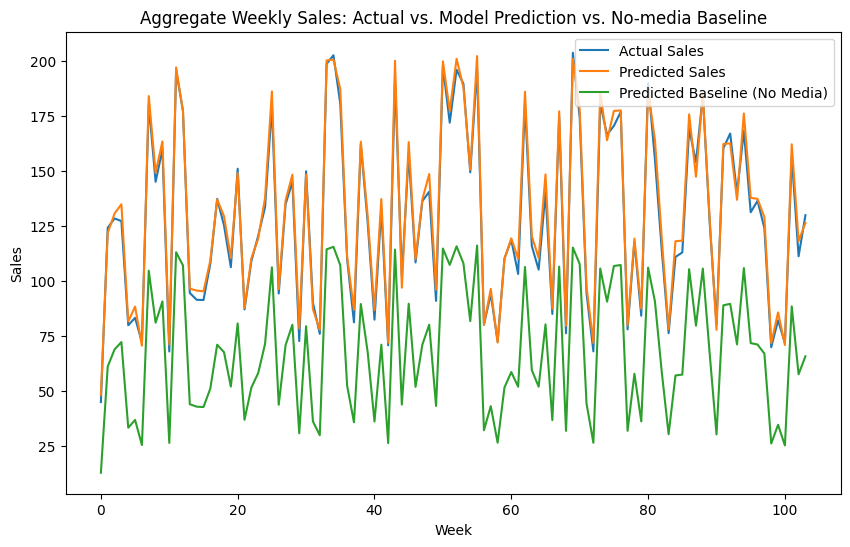

In [12]:
# Full vs. Baseline Autoregressive Rollout & Plot
model.load_state_dict(best_wts)
model.eval()
geo_idx = torch.arange(N_GEOS, device=DEVICE)

Xf = torch.tensor(X, dtype=torch.float32, device=DEVICE).clone()
Xb = Xf.clone()
Xb[..., :NUM_CHANNELS, :] = 0.0  # zero out _all_ embed dims for media channels

yf = np.zeros((N_GEOS, TIME_STEPS, 2), dtype=np.float32)
yb = np.zeros_like(yf)

with torch.no_grad():
    for t in range(TIME_STEPS):
        out_f = model(Xf[:, : t + 1], geo_idx)  # (G, t+1, 2)
        out_b = model(Xb[:, : t + 1], geo_idx)

        yf[:, t, :] = out_f[:, -1, :].cpu().numpy()
        yb[:, t, :] = out_b[:, -1, :].cpu().numpy()

        if t + 1 < TIME_STEPS:
            pred_search_f = out_f[:, -1, 1]
            pred_search_b = out_b[:, -1, 1]

    out_full = model(Xf, geo_idx).cpu().numpy()  # (G, T, 2)
    out_base = model(Xb, geo_idx).cpu().numpy()

sales_full_raw = np.expm1(out_full[..., 0])
sales_base_raw = np.expm1(out_base[..., 0])

actual_total_sales = sales.sum(axis=0)  # (T,)
pred_total_sales = sales_full_raw.sum(axis=0)
pred_baseline_sales = sales_base_raw.sum(axis=0)

plt.figure(figsize=(10, 6))
plt.plot(actual_total_sales, label="Actual Sales")
plt.plot(pred_total_sales, label="Predicted Sales")
plt.plot(pred_baseline_sales, label="Predicted Baseline (No Media)")
plt.title("Aggregate Weekly Sales: Actual vs. Model Prediction vs. No-media Baseline")
plt.xlabel("Week")
plt.ylabel("Sales")
plt.legend()
plt.show()


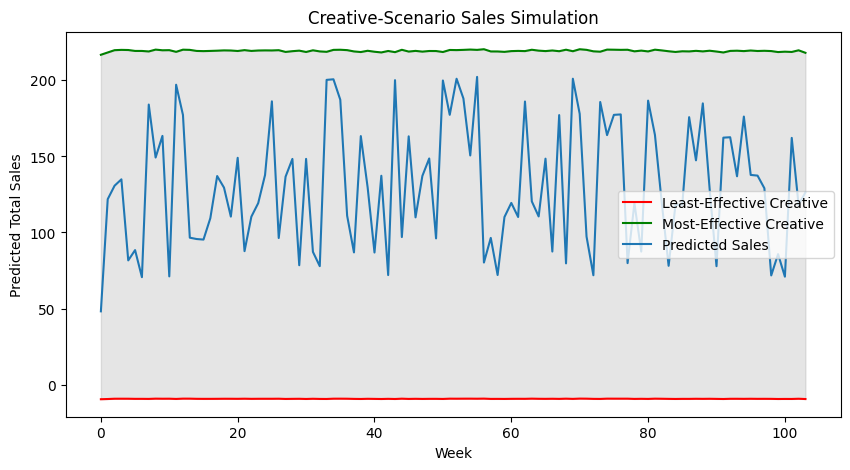

In [13]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# ─── 0) Assumptions ─────────────────────────────────────────────────────────────
# - best_wts, model, DEVICE, N_GEOS, TIME_STEPS, NUM_CHANNELS are already defined
# - X is your original input array of shape (N_GEOS, TIME_STEPS, NUM_CHANNELS, EMBED_DIM)
# - embeddings is your (104,256) NumPy array from the Keras pipeline

# ─── 1) Prep model + data ──────────────────────────────────────────────────────
model.load_state_dict(best_wts)
model.to(DEVICE).eval()
geo_idx = torch.arange(N_GEOS, device=DEVICE)

Xf = torch.tensor(X, dtype=torch.float32, device=DEVICE).clone()

# ─── 2) Build the two “flat” creative scenarios ─────────────────────────────────
# choose the channel index where your creative embedding lives:
creative_chan = -2 # NUM_CHANNELS    # ← adjust if needed

# get the single-vector least/most embeddings
least_vec = torch.tensor(creative_embeddings[id_worst], dtype=Xf.dtype, device=DEVICE)  # worst creative
most_vec  = torch.tensor(creative_embeddings[id_best], dtype=Xf.dtype, device=DEVICE)  # best creative

# expand to shape (N_GEOS, TIME_STEPS, EMBED_DIM)
least_full = least_vec.unsqueeze(0).unsqueeze(0).repeat(N_GEOS, TIME_STEPS, 1)
most_full  = most_vec.  unsqueeze(0).unsqueeze(0).repeat(N_GEOS, TIME_STEPS, 1)

# clone and replace that channel
X_least = Xf.clone()
X_most  = Xf.clone()
X_least[..., creative_chan, :] = least_full
X_most[ ..., creative_chan, :] = most_full

# ─── 3) Predict in one go (no need for autoregressive loop here) ───────────────
with torch.no_grad():
    out_least = model(X_least,geo_idx).cpu().numpy()
    out_most  = model(X_most, geo_idx).cpu().numpy()

# extract & sum the “sales” channel (assumed index 0), and invert log1p:
sales_least = np.expm1(out_least[..., 0]).sum(axis=0)
sales_most  = np.expm1(out_most[...,  0]).sum(axis=0)

# ─── 4) Plot all three with shading ─────────────────────────────────────────────
weeks = np.arange(TIME_STEPS)

plt.figure(figsize=(10,5))
plt.plot(weeks, sales_least, color='red',   label='Least-Effective Creative')
plt.plot(weeks, sales_most,  color='green', label='Most-Effective Creative')
plt.fill_between(weeks, sales_least, sales_most, color='grey', alpha=0.2)
plt.plot(pred_total_sales, label="Predicted Sales")
plt.xlabel("Week")
plt.ylabel("Predicted Total Sales")
plt.title("Creative-Scenario Sales Simulation")
plt.legend()
plt.show()


---
# Scenario planner with multipler on the spend




Scenario planner:

 A DataFrame df showing how sales and search vary under each investment scenario.
 A simple line plot of total predicted sales against spend multiplier.



In [15]:
import torch
import pandas as pd

def scenario_planner_per_channel(
    model,
    X,
    channel_multipliers: list,
    geo_idx: int = None,
    time_step: int = None,
    device: torch.device = DEVICE,
):
    """
    Simulate “what-if” scenarios by scaling each media channel separately,
    optionally for a single time step or for all time steps.

    Args:
      model               : trained NNNModel (in eval mode, on `device`)
      X                   : np.ndarray or torch.Tensor, shape (N_GEOS, T, C_in, D)
      channel_multipliers : list of length NUM_CHANNELS, one multiplier per channel
      geo_idx             : int or None → simulate only that geo, or all if None
      time_step           : int or None → if None apply to all weeks, else only to that week index
      device              : torch.device

    Returns:
      DataFrame with columns [
        "geo_idx",
        "time_step",
        "multipliers",
        "total_sales",
        "avg_search"
      ]
    """
    model.eval()
    # ensure tensor on correct device
    if not isinstance(X, torch.Tensor):
        X_t = torch.tensor(X, dtype=torch.float32, device=device)
    else:
        X_t = X.to(device)

    # validate channel multipliers
    assert len(channel_multipliers) == NUM_CHANNELS, (
        f"Need {NUM_CHANNELS} multipliers, got {len(channel_multipliers)}"
    )

    # decide which geos to simulate
    geos = [geo_idx] if geo_idx is not None else list(range(X_t.shape[0]))
    results = []

    for g in geos:
        # extract & clone base input for this geo
        X_base = X_t[g : g + 1].clone()  # (1, T, C_in, D)

        # apply multipliers
        if time_step is None:
            # scale each channel across all time steps
            for j, m in enumerate(channel_multipliers):
                X_base[:, :, j, :] *= m
        else:
            # scale only the specified week
            t = time_step
            for j, m in enumerate(channel_multipliers):
                X_base[:, t, j, :] *= m

        # forward pass
        with torch.no_grad():
            Y_pred = model(X_base, torch.tensor([g], device=device))
            total_sales = torch.expm1(Y_pred[..., 0]).sum().item()
            avg_search   = torch.expm1(Y_pred[..., 1]).mean().item()

        results.append({
            "geo_idx":      g,
            "time_step":    time_step if time_step is not None else "all",
            "multipliers":  channel_multipliers.copy(),
            "total_sales":  total_sales,
            "avg_search":   avg_search
        })

    return pd.DataFrame(results)


## Testing the scenario planner function

In [16]:
# (a) Per-channel multipliers for a single geo at one specific week
# Apply twice‐TV on channel 0, 50% on channel 1, leave others unchanged, for geo 2 at week 10.
muls = [2.0, 0.5, 1.0, 1.0]
df_geo2_week10 = scenario_planner_per_channel(
    model,
    X,
    channel_multipliers=muls,
    geo_idx=2,
    time_step=10,
    device=DEVICE
)
print(df_geo2_week10)



# (b) changing the marketing mix

# e.g. double TVCM, 1.2× YouTube, half Taxi, 0.8× Display
muls = [2.0, 1.2, 0.5, 0.8]

All-geos scenario
df_all = scenario_planner_per_channel(model, X, muls, geo_idx=None)
print(df_all)


# (c) changing the overall investment level
import numpy as np
import matplotlib.pyplot as plt

# Coefficients to scale the uniform multipliers
coefs = [0.5, 1.0, 1.5, 2.0, 2.5]
NUM_CHANNELS = len(MEDIA_CHANNELS)  # assume defined elsewhere, e.g. 4

# Will hold the total predicted sales across all geos for each coef
agg_sales = []

for c in coefs:
    # Build a uniform per‐channel multiplier list [c, c, …, c]
    muls = [c] * NUM_CHANNELS

    # Run the scenario for ALL geos (geo_idx=None)
    df = scenario_planner_per_channel(
        model,
        X,
        channel_multipliers=muls,
        geo_idx=None,
        device=DEVICE
    )
    # Sum sales over all geos
    total_sales_all_geos = df["total_sales"].sum()
    agg_sales.append(total_sales_all_geos)

# Plot overall predicted sales vs. spend‐scale coefficient
plt.figure()
plt.plot(coefs, agg_sales, marker="o")
plt.title("Total Predicted Sales Across All Geos vs. Uniform Spend Scale")
plt.xlabel("Uniform Spend Scale Coefficient")
plt.ylabel("Total Predicted Sales (sum over geos)")
plt.grid(True)
plt.show()




SyntaxError: invalid syntax (ipython-input-16-3212351995.py, line 21)

## Scenario Planner on Creative Piece

In [17]:
import torch
import numpy as np
import pandas as pd

def scenario_planner_creative(
    model: torch.nn.Module,
    X: np.ndarray,                 # shape (N_GEOS, T, C, D)
    creative_piece: str,
    tokeniser,                     # function: list[str] → np.ndarray (len×256)
    geo_idx: int = None,
    time_step: int = None,
    creative_chan: int = -2,       # index of creative channel in X
    device: torch.device = DEVICE
) -> str:
    """
    Simulate replacing the creative embedding with that of `creative_piece`.
    Always returns a single summary sentence (for one week or all weeks).
    """
    model.to(device).eval()

    # 1) Embed & normalize the creative piece
    emb_np = tokeniser([creative_piece])        # (1,256) using global scaler
    emb256 = torch.tensor(emb_np[0],
                         dtype=torch.float32,
                         device=device)         # (256,)

    # 2) Prepare X tensor
    X_t = torch.tensor(X, dtype=torch.float32, device=device)  # (N, T, C, D)
    N, T, C, D = X_t.shape
    t = time_step if time_step is not None else T - 1
    geos = [geo_idx] if geo_idx is not None else list(range(N))

    # 3) Compute base vs scenario
    base_total = 0.0
    scn_total  = 0.0
    for g in geos:
        X_base = X_t[g:g+1].clone()            # (1, T, C, D)
        X_scn  = X_base.clone()
        if time_step is None:
            X_scn[0, :, creative_chan, :] = emb256
        else:
            X_scn[0, t, creative_chan, :] = emb256

        idx = torch.tensor([g], device=device)
        with torch.no_grad():
            Y_base = model(X_base, idx).cpu().numpy()
            Y_scn  = model(X_scn,  idx).cpu().numpy()

        base_vec = np.expm1(Y_base[0, :, 0])
        scn_vec  = np.expm1(Y_scn[0,  :, 0])

        if time_step is None:
            base_sales = base_vec.sum()
            scn_sales  = scn_vec.sum()
        else:
            base_sales = base_vec[t]
            scn_sales  = scn_vec[t]

        base_total += base_sales
        scn_total  += scn_sales

    # 4) Build & return single summary sentence with emoji
    uplift = (scn_total - base_total) / (base_total + 1e-9) * 100
    if time_step is None:
        print (f"📊 Total projected sales across all geos: {scn_total:.2f} "
                f"(baseline {base_total:.2f}), uplift {uplift:.1f}% 🚀")
    else:
        print (f"📊 Week {t} projected sales: {scn_sales:.2f} "
                f"(baseline {base_sales:.2f}), uplift {uplift:.1f}% 🚀")
    return emb256 #Y_scn


In [18]:
df = scenario_planner_creative(
    model,
    X,
    creative_piece="Demand is really high . take advantage of  Apple’s deepest 30% discount on our flagship devices. Your future self will thank you.",
    tokeniser=tokeniser,
    #geo_idx=3,            # optional: single geo
    #time_step=10,         # optional: single week
    #creative_chan=-2,      # adjust to your channel index
    device=DEVICE
)


📊 Total projected sales across all geos: 23131.39 (baseline 13617.54), uplift 69.9% 🚀


# Attribution

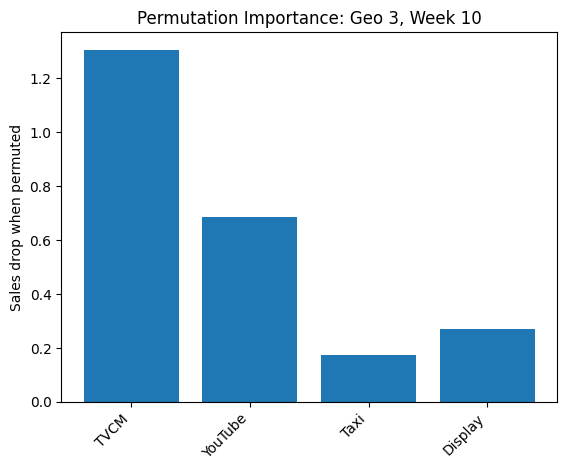

In [19]:
import numpy as np
from sklearn.metrics import r2_score

def permutation_importance(
    model, X, y_true,                                # your trained model, inputs & true sales
    geo_idx: int, time_step: int,                    # the geo & week you’re analyzing
    channel_idx: int                                 # which media channel to permute
):
    # 1) baseline prediction
    df_base = scenario_planner_per_channel(
        model, X, [1.0]*NUM_CHANNELS, geo_idx=geo_idx, time_step=time_step, device=DEVICE
    )
    base_sales = df_base["total_sales"].iat[0]

    # 2) permute that one channel’s embedding/time series across geos
    X_perm = X.copy()
    # shuffle the entire time-series for channel j across geos
    np.random.shuffle(X_perm[:, :, channel_idx, :])

    # 3) re-predict
    df_perm = scenario_planner_per_channel(
        model, X_perm, [1.0]*NUM_CHANNELS, geo_idx=geo_idx, time_step=time_step, device=DEVICE
    )
    perm_sales = df_perm["total_sales"].iat[0]

    # 4) importance = drop in sales
    return base_sales - perm_sales

# Compute importances for all channels at geo=3, week=10
importances = []
for j in range(NUM_CHANNELS):
    imp = permutation_importance(model, X, None, geo_idx=3, time_step=10, channel_idx=j)
    importances.append(imp)

# Plot
import matplotlib.pyplot as plt
plt.bar(MEDIA_CHANNELS, importances)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Sales drop when permuted")
plt.title("Permutation Importance: Geo 3, Week 10")
plt.show()


# Actionable Insights on Creative Pieces

In [20]:
!pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 82.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [21]:
import torch
import numpy as np
from captum.attr import IntegratedGradients

# 1) Prepare X_single and a Long geo_idx tensor
geo_id = 3
X_single = torch.tensor(X[geo_id:geo_id+1],
                        dtype=torch.float32,
                        device=DEVICE)     # shape (1, T, C, D)
geo_idx_single = torch.tensor([geo_id],
                              dtype=torch.long,
                              device=DEVICE)  # shape (1,)

# 2) Wrap model to return a (B,) sales sum vector
def forward_fn(x, g):
    out = model(x, g)              # (B, T, 2)
    return out[..., 0].sum(dim=1)  # (B,)

# 3) Set up IG and attribute
ig = IntegratedGradients(forward_fn)
attr, delta = ig.attribute(
    inputs=X_single,
    additional_forward_args=(geo_idx_single,),
    target=None,
    n_steps=50,
    return_convergence_delta=True
)
# attr: (1, T, C, D)

# 4) Collapse to per-dimension impact on creative channel
creative_chan = -2 #Modify if needed
impact_per_dim = (
    attr[0, :, creative_chan, :]  # (T, D)
    .abs()
    .mean(dim=0)                  # (D,)
    .cpu()
    .numpy()
)

# 5) Get top-k dims
top_k = 5
top_dims = np.argsort(-impact_per_dim)[:top_k]
print("Top dims:", top_dims)


Top dims: [163  44  17  82 103]


In [22]:
import numpy as np
import torch

# ─── 1) Build the set of subword tokens actually used in your creatives ───────
corpus_subtokens = set()
for text in messages:
    for t in tokenizer.tokenize(text):
        corpus_subtokens.add(t)

# parallel lists of corpus tokens and their IDs
token2id = tokenizer.get_vocab()               # token → id
corpus_subtokens_list = list(corpus_subtokens)
corpus_ids_list      = [token2id[t] for t in corpus_subtokens_list]

# ─── 2) Build the “outside” token list: full vocab minus corpus, only whole words ─
all_tokens    = list(token2id.keys())
outside_tokens = [
    t for t in all_tokens
    if ("##" not in t) and (t not in corpus_subtokens)
]
outside_ids_list = [token2id[t] for t in outside_tokens]

# ─── 3) Compute effective 256×V embedding contributions E[d, i] ────────────────
token_embeds = bert_model.embeddings.word_embeddings.weight.data   # [V,768]
proj_w       = project256.weight.data                               # [256,768]
E_np         = (proj_w @ token_embeds.t()).cpu().numpy()           # (256, V)

# ─── 4) For each important embedding dimension, pick:
#      • Top 3 from your own creatives
#      • Top 10 suggestions from outside vocab
top_k_in  = 3
top_k_out = 5

for d in top_dims:
    # --- in-corpus top 3 ---
    w_in       = E_np[d, corpus_ids_list]                    # weights for corpus tokens
    best_in_i  = np.argsort(-w_in)[:top_k_in]                # top indices in corpus_ids_list
    best_in    = [corpus_subtokens_list[i].lstrip("##")      # strip any '##'
                  for i in best_in_i]

    # --- outside top 10 ---
    w_out      = E_np[d, outside_ids_list]                   # weights for outside tokens
    best_out_i = np.argsort(-w_out)[:top_k_out]
    best_out   = [outside_tokens[i]                           # already whole words
                  for i in best_out_i]

    print(f"Dimension {d:3d}:")
    print(f"  • Top–3 from your creatives: {best_in}")
    print(f"  • Top–10 new suggestions:    {best_out}")
    print()


Dimension 163:
  • Top–3 from your creatives: ['choice', 'feature', 'straightforward']
  • Top–10 new suggestions:    ['pitted', '§', 'spend', 'can', 'skylar']

Dimension  44:
  • Top–3 from your creatives: ['+', 'purchases', 'sustainable']
  • Top–10 new suggestions:    ['blow', 'ramps', 'dickinson', 'slides', 'restored']

Dimension  17:
  • Top–3 from your creatives: ['thank', 'spark', 'vibe']
  • Top–10 new suggestions:    ['dal', 'cheat', 'owls', 'knights', 'cradle']

Dimension  82:
  • Top–3 from your creatives: ['across', 'fr', 'iphone']
  • Top–10 new suggestions:    ['sweat', 'ego', 'mayfair', 'chinatown', 'kato']

Dimension 103:
  • Top–3 from your creatives: ['ill', 'select', 'great']
  • Top–10 new suggestions:    ['cross', 'diver', 'whoever', 'button', 'brake']



In [24]:
import numpy as np
import torch

# ─── Prerequisites (assumed computed earlier) ────────────────────────────────
# impact_per_dim : np.ndarray shape (256,)  ← your IG attribution vector
# E_np           : np.ndarray shape (256, V) ← proj_w @ token_embeds.T
# tokenizer      : BertTokenizer
# token2id       : dict mapping token → id
# messages       : list of your 104 creative strings

# ─── 1) Compute a score for every vocab token ────────────────────────────────
# scores[i] = how much token i aligns with the sales‐direction
scores = impact_per_dim @ E_np  # shape: (V,)

# ─── 2) Prepare your “creative‐piece” token set ──────────────────────────────
corpus_subtokens = set()
for text in messages:
    for subtok in tokenizer.tokenize(text):
        # strip '##' so we unify root pieces / whole words
        corpus_subtokens.add(subtok.lstrip("##"))

# only keep those that actually exist in BERT’s vocab
corpus_tokens = [t for t in corpus_subtokens if t in token2id]

# ─── 3) Score & rank corpus tokens ──────────────────────────────────────────
corpus_scores = [(t, scores[token2id[t]]) for t in corpus_tokens]
corpus_scores.sort(key=lambda x: -x[1])
top_k_corpus = [t for t,_ in corpus_scores[:10]]

# ─── 4) Prepare your “overall dictionary” token set ─────────────────────────
# only whole words (no '##') from the full BERT vocab
global_tokens = [t for t in token2id.keys() if "##" not in t]

# ─── 5) Score & rank global dictionary tokens ──────────────────────────────
global_scores = [(t, scores[token2id[t]]) for t in global_tokens]
global_scores.sort(key=lambda x: -x[1])
top_k_global = [t for t,_ in global_scores[:10]]

# ─── 6) Print your recommendations ──────────────────────────────────────────
print(f"🎯 Top 10 sales-driving words from your existing creatives:\n  • " +
      "   • ".join(top_k_corpus))
print(f"🎉 Top 10 fresh word ideas from the full BERT vocabulary:\n  • " +
      "   • ".join(top_k_global))



🎯 Top 10 sales-driving words from your existing creatives:
  • click   • thank   • track   • will   • moves   • mini   • before   • every   • to   • and
🎉 Top 10 fresh word ideas from the full BERT vocabulary:
  • moods   • [CLS]   • might   • wills   • dil   • dare   • jul   • handed   • can   • chinatown


# Impluse Response analysis


>  An Impulse response analysis of what would happen if we have only an impluse investment signal




In [25]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Function: impulse response analysis with flexible inputs
def impulse_response_analysis(
    model,
    X: np.ndarray,
    media_spend: np.ndarray,
    std_multiplier: float = 1.0,
    raw_increase: float = None,
    channel_idx: int = None,
    time_step: int = None,
    geo_idx: int = None,
    device: torch.device = DEVICE,
):
    """
    Flexible impulse-response: bump spend by std or raw, plot %Δ sales.

    Args:
      model         : trained NNNModel (eval mode)
      X             : array, shape (G, T, C_in, D)
      media_spend   : array, shape (G, T, C)
      std_multiplier: number of σ to add (unless raw_increase provided)
      raw_increase  : direct spend addition (mutually exclusive with std_multiplier)
      channel_idx   : int or None → which channel (None=all)
      time_step     : int or None → which week (None=0)
      geo_idx       : int or None → which geo (None=all)
      device        : torch.device

    Returns:
      dict mapping channel→delta_pct array of shape (T,)
    """
    # Check exclusivity
    if (raw_increase is not None) and (std_multiplier is not None and std_multiplier != 1.0):
        raise ValueError("Specify either raw_increase or std_multiplier, not both.")

    # Prepare tensors
    X_t = torch.tensor(X, dtype=torch.float32, device=device)
    G, T, C_in, D = X_t.shape
    full_geo_ids = torch.arange(G, device=device)
    model.eval()
    eps = 1e-9

    # Baseline sales
    with torch.no_grad():
        Yb = model(X_t, full_geo_ids)
    sales_base = torch.expm1(Yb[..., 0]).cpu().numpy()

    # Compute std devs of raw spend
    std_rg = np.std(media_spend, axis=1)

    # Determine indices
    geos = [geo_idx] if geo_idx is not None else list(range(G))
    channels = [channel_idx] if channel_idx is not None else list(range(media_spend.shape[2]))
    t = time_step if time_step is not None else 0

    # Plot setup
    n = len(channels)
    rows = int(np.ceil(n/2))
    cols = min(2, n)
    fig, axes = plt.subplots(rows, cols, figsize=(14, 5*rows), sharex=True)
    axes = np.array(axes).reshape(-1)
    # Define x-axis range from injection time t to t+12 (inclusive)
    start = t
    end = min(T, t + 13)
    weeks = np.arange(start, end)  # plot from week t to t+12

    delta_pct_dict = {}

    # Impulse-response per channel
    for idx, j in enumerate(channels):
        ax = axes[idx]
        X_scen = X_t.clone()

        # Apply bump per geo
        for g in geos:
            base = media_spend[g, t, j]
            if raw_increase is not None:
                inc = raw_increase
            else:
                inc = std_rg[g, j] * std_multiplier
            s_prime = base + inc
            # rebuild embedding vector
            v_val = torch.log1p(torch.tensor(s_prime, device=device))  # scalar tensor
            V = v_val.repeat(D)                                       # (D,)
            norm = torch.norm(V)
            E = (V / (norm + eps)) * torch.log1p(norm)               # (D,)
            X_scen[g, t, j, :] = E

        # Predict scenario
        with torch.no_grad():
            Yi = model(X_scen, full_geo_ids)
        sales_imp = torch.expm1(Yi[..., 0]).cpu().numpy()

        # Aggregate & compute percentage delta
        total_base = sales_base.sum(axis=0)
        total_imp = sales_imp.sum(axis=0)
        delta = total_imp - total_base
        delta_pct = (delta / (total_base + eps)) * 100
        delta_pct_dict[j] = delta_pct

        # Plot
        ax.plot(weeks, delta_pct[start:end], marker='o')  # plot Δ% sales from t to t+12
        title = MEDIA_CHANNELS[j] if channel_idx is None else f"Channel {channel_idx}"
        ax.set_title(f"Impulse response of the channel: {title}")
        ax.set_xlabel("Week")
        ax.set_ylabel("Δ Sales (%)")
        ax.grid(True)

        # Annotation position based on first value
        first_val = delta_pct[0]
        if first_val < 0:
            xpos, ypos, va, ha = 0.98, 0.02, 'bottom', 'right'
        else:
            xpos, ypos, va, ha = 0.98, 0.98, 'top', 'right'
        # Summary text
        label = f"Added raw +{raw_increase:.2f}" if raw_increase is not None else f"Added {std_multiplier:.1f}σ"
        # cumulative percentage change over first 3 weeks starting at t
        dS1 = delta_pct[start:start+3].sum()
        # cumulative percentage change over first 13 weeks starting at t
        dS2 = delta_pct[start:end].sum()
        # annotation text showing ranges relative to injection time t
        txt = (
            f"{label} at t={t}\n"
            f"Δ% Sales ({t}–{t+2}): {dS1:.1f}%\n"
            f"Δ% Sales ({t}–{end-1}): {dS2:.1f}%: {dS1:.1f}%\n"
            f"Δ% Sales (0–{len(weeks)-1}): {dS2:.1f}%"
        )
        ax.text(xpos, ypos, txt,
                transform=ax.transAxes, fontsize=9,
                va=va, ha=ha,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray", alpha=0.8)
        )


    plt.suptitle("Impulse Response Analysis", y=1.02)
    plt.tight_layout(rect=[0,0,1,0.96])
    plt.show()

    return delta_pct_dict

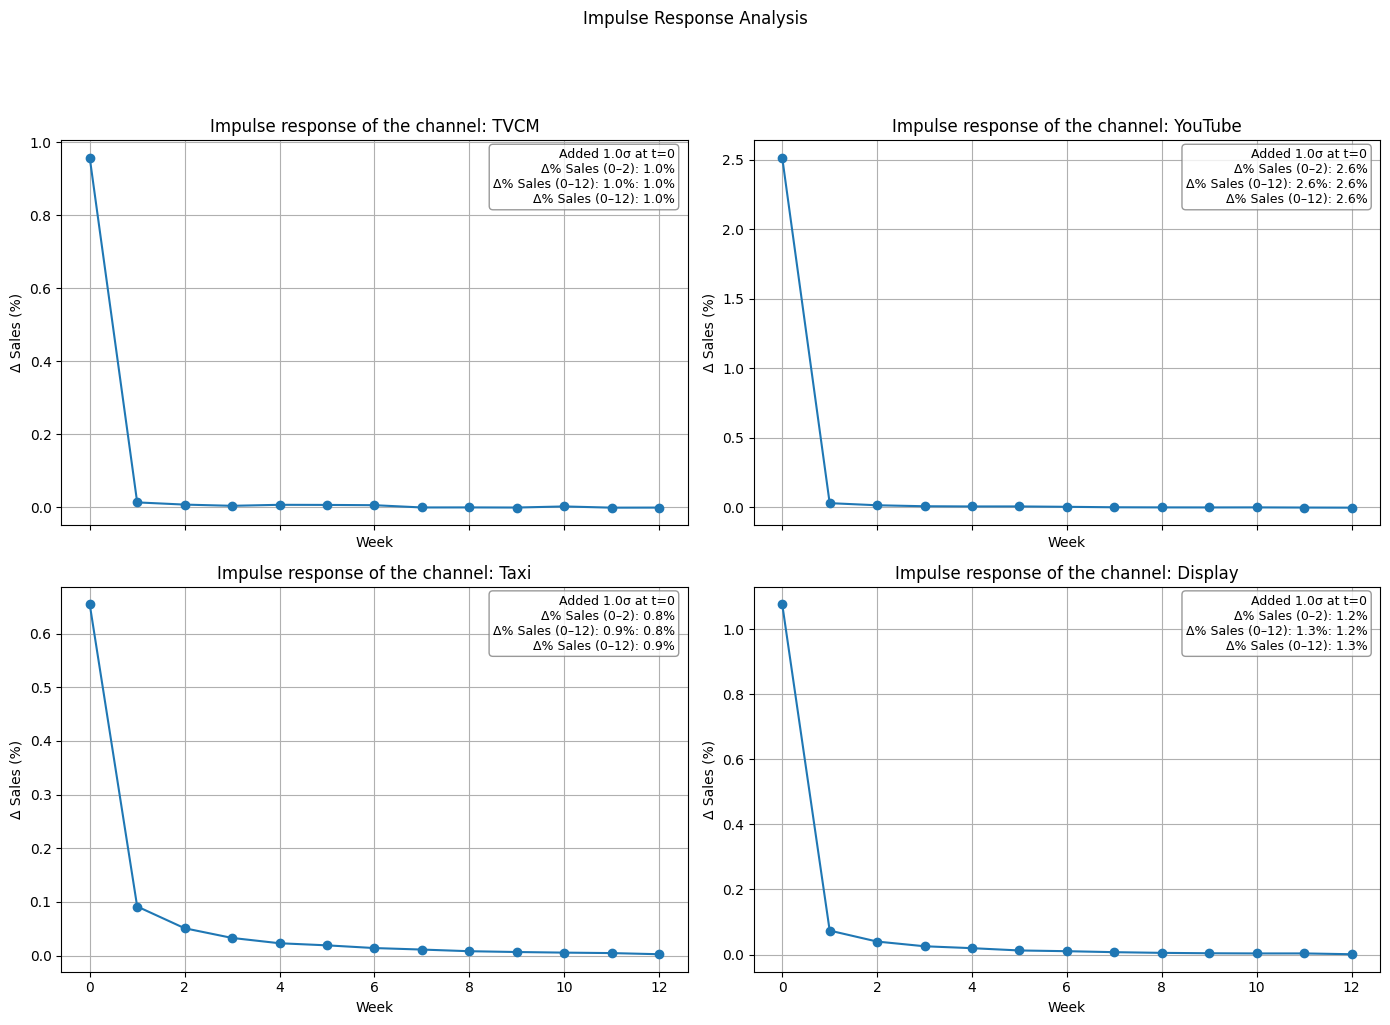

In [26]:

# Example usage:
# 1) all channels, all geos, t=0 (default), 1σ
_ = impulse_response_analysis(model, X, media_spend)
# # 2) all channels, all geos, t=52
# _ = impulse_response_analysis(model, X, media_spend, time_step=52)
# # 3) all channels, all geos, t=78 (104-26)
# _ = impulse_response_analysis(model, X, media_spend, time_step=104-26)
# # 4) all channels, all geos, t=91 (104-13)
# _ = impulse_response_analysis(model, X, media_spend, time_step=104-13)

## Animation of the impluse response

In [27]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display

# Multi-channel impulse response animation in 4 subplots
# Assumes:
#   X            : np.ndarray (N_GEOS, TIME_STEPS, CHANNEL_COUNT_INPUT, EMBED_DIM)
#   media_spend  : np.ndarray (N_GEOS, TIME_STEPS, NUM_CHANNELS)
#   model        : trained NNNModel on DEVICE
#   DEVICE, MEDIA_CHANNELS, TIME_STEPS, EMBED_DIM defined

# Prepare tensors
device = DEVICE
X_t = torch.tensor(X, dtype=torch.float32, device=device)            # (G, T, C_in, D)
full_geo_ids = torch.arange(X_t.shape[0], device=device)

model.eval()
eps = 1e-9

# Baseline total sales across geos
with torch.no_grad():
    Yb = model(X_t, full_geo_ids)                                     # (G, T, 2)
sales_base = torch.expm1(Yb[..., 0]).cpu().numpy().sum(axis=0)       # (T,)

# Per-geo std dev for each channel
std_rg = np.std(media_spend, axis=1)  # (G, C)
num_channels = media_spend.shape[2]

# Create 2x2 subplots for four channels
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.flatten()
lines = []
for ax in axes:
    ln, = ax.plot([], [], lw=2, marker='o')
    lines.append(ln)

# Initial axes formatting
for idx, ax in enumerate(axes):
    ax.set_xlim(1, 13)
    ax.set_ylim(-0.70, 1.50)
    ax.set_xlabel("Week")
    ax.set_ylabel("Δ Sales (%)")
    ax.set_title(f"{MEDIA_CHANNELS[idx]}")
    ax.grid(axis='y')

# Initialization

def init():
    for ln in lines:
        ln.set_data([], [])
    return lines

# Update function for frames t=1..13

def update(t):
    # For each channel, simulate impulse and update its line
    for j, ln in enumerate(lines):
        # Clone base inputs for channel j
        X_scen = X_t.clone()
        # Compute raw spend + 1σ at week t for channel j
        s = media_spend[:, t, j]           # (G,)
        inc = std_rg[:, j]
        s_prime = s + inc
        # Rebuild embedding only for channel j at week t
        for g in range(X_scen.shape[0]):
            v = torch.log1p(torch.tensor(s_prime[g], device=device))
            V = v.repeat(EMBED_DIM)
            norm = torch.norm(V)
            E = (V / (norm + eps)) * torch.log1p(norm)
            X_scen[g, t, j, :] = E

        # Predict under this single-channel impulse
        with torch.no_grad():
            Yi = model(X_scen, full_geo_ids)                             # (G, T, 2)
        sales_imp = torch.expm1(Yi[..., 0]).cpu().numpy().sum(axis=0)   # (T,)

        # Compute percentage change vs baseline
        delta_pct = (sales_imp - sales_base) / (sales_base + eps) * 100
        weeks = np.arange(1, 14)

        # Update line for channel j
        ln.set_data(weeks, delta_pct[1:14])

    # Update subplot titles to include frame info
    for idx, ax in enumerate(axes):
        ax.set_title(f"Impulse: {MEDIA_CHANNELS[idx]} at t={t}")

    return lines

# Create animation
ani = FuncAnimation(
    fig,
    update,
    frames=range(1, 14),
    init_func=init,
    blit=False,
    repeat=False
)
plt.tight_layout()
# Display inline
html_anim = HTML(ani.to_jshtml())
plt.close(fig)
display(html_anim)


In [28]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display

# Multi-channel impulse response animation in 4 subplots
# Assumes:
#   X            : np.ndarray (N_GEOS, TIME_STEPS, CHANNEL_COUNT_INPUT, EMBED_DIM)
#   media_spend  : np.ndarray (N_GEOS, TIME_STEPS, NUM_CHANNELS)
#   model        : trained NNNModel on DEVICE
#   DEVICE, MEDIA_CHANNELS, TIME_STEPS, EMBED_DIM defined

# Prepare tensors
device = DEVICE
X_t = torch.tensor(X, dtype=torch.float32, device=device)            # (G, T, C_in, D)
full_geo_ids = torch.arange(X_t.shape[0], device=device)

model.eval()
eps = 1e-9

# Baseline total sales across geos
with torch.no_grad():
    Yb = model(X_t, full_geo_ids)                                     # (G, T, 2)
sales_base = torch.expm1(Yb[..., 0]).cpu().numpy().sum(axis=0)       # (T,)

# Per-geo std dev for each channel
std_rg = np.std(media_spend, axis=1)  # (G, C)
num_channels = media_spend.shape[2]

# Precompute global delta range (t=1..13 for all channels) for static y-limits
all_deltas = []
for t0 in range(1, 14):
    X_temp = X_t.clone()
    for j in range(num_channels):
        s = media_spend[:, t0, j]
        inc = std_rg[:, j]
        s_prime = s + inc
        for g in range(X_temp.shape[0]):
            v = torch.log1p(torch.tensor(s_prime[g], device=device))
            V = v.repeat(EMBED_DIM)
            norm = torch.norm(V)
            E = (V / (norm + eps)) * torch.log1p(norm)
            X_temp[g, t0, j, :] = E
    with torch.no_grad():
        Yt = model(X_temp, full_geo_ids)
    sales_imp_t = torch.expm1(Yt[..., 0]).cpu().numpy().sum(axis=0)
    delta_t = (sales_imp_t - sales_base) / (sales_base + eps) * 100
    all_deltas.append(delta_t[1:14])
all_deltas = np.concatenate(all_deltas)
min_all = all_deltas.min()
max_all = all_deltas.max()
# static y-limits: 10% buffer
low = min_all * 1.1 if min_all < 0 else 0
high = max_all * 1.1

# Create 2x2 subplots for four channels
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.flatten()
lines = []
for ax in axes:
    ln, = ax.plot([], [], lw=2, marker='o')
    lines.append(ln)

for idx, ax in enumerate(axes):
    ax.set_xlim(1, 13)
    ax.set_ylim(low, high)
    ax.set_xlabel("Week")
    ax.set_ylabel("Δ Sales (%)")
    ax.set_title(f"{MEDIA_CHANNELS[idx]}")
    ax.grid(axis='y')

# Initialization

def init():
    for ln in lines:
        ln.set_data([], [])
    return lines

# Update function for frames t=1..13

def update(t):
    # Determine plotting window
    start = max(0, t-1)
    end = min(TIME_STEPS-1, t+13)
    weeks = np.arange(start, end+1)

    # For each channel, simulate impulse and update its line
    for j, ln in enumerate(lines):
        # Clone base inputs
        X_scen = X_t.clone()
        # Compute raw spend + 1σ at time t for channel j
        s = media_spend[:, t, j]
        inc = std_rg[:, j]
        s_prime = s + inc
        # Rebuild embedding only for channel j at time t
        for g in range(X_scen.shape[0]):
            v = torch.log1p(torch.tensor(s_prime[g], device=device))
            V = v.repeat(EMBED_DIM)
            norm = torch.norm(V)
            E = (V / (norm + eps)) * torch.log1p(norm)
            X_scen[g, t, j, :] = E

        # Predict under this single-channel impulse
        with torch.no_grad():
            Yi = model(X_scen, full_geo_ids)
        sales_imp = torch.expm1(Yi[..., 0]).cpu().numpy().sum(axis=0)

        # Compute percentage change vs baseline
        delta_pct = (sales_imp - sales_base) / (sales_base + eps) * 100

        # Update line for channel j
        ln.set_data(weeks, delta_pct[start:end+1])

    # Keep x-limits consistent
    for ax in axes:
        ax.set_xlim(start, end)

    # Update subplot titles with frame info
    for idx, ax in enumerate(axes):
        ax.set_title(f"Impulse: {MEDIA_CHANNELS[idx]} at t={t}")

    return lines

# Create animation
ani = FuncAnimation(
    fig,
    update,
    frames=range(1, 14),
    init_func=init,
    blit=False,
    repeat=False
)
plt.tight_layout()
# Display inline
html_anim = HTML(ani.to_jshtml())
plt.close(fig)
display(html_anim)


# Save Workspace

In [29]:
to_save = [
    'ALPHA',
    'BATCH_SIZE',
    'BertModel',
    'BertTokenizer',
    'CHANNEL_COUNT_INPUT',
    'C_in',
    'C',
    'DEVICE',
    'Dataset',
    'DataLoader',
    'DROPOUT',
    'E_np',
    'EMBED_DIM',
    'F',
    'FuncAnimation',
    'GEOS',
    'GeoTimeSeriesDataset',
    'GRAD_NOISE_STD',
    'GRUCell',
    'HIDDEN_CHANNELS',
    'HTML',
    'IDX',
    'IN_CHANNELS',
    'IntegratedGradients',
    'LAYERS',
    'L1_LAMBDA',
    'LEARNING_RATE',
    'LOGGING',
    'LOOKBACK_WINDOW',
    'MAX_GRAD_NORM',
    'MEDIA_CHANNELS',
    'MODEL_PATH',
    'NEG_INF',
    'N_GEOS',
    'NUM_EPOCHS',
    'OPTIMIZER',
    'P',
    'PERIODS',
    'SCENARIO',
    'SIMULATOR',
    'SLIDING_WINDOW',
    'STATE_DIM',
    'TAG',
    'TARGET',
    'TEST_SIZE',
    'TRAIN_SIZE',
    'TS',
    'TYPE',
    'USE_SIMULATED',
    'W',
    'WEIGHT_DECAY',
    'X_np',
    'Y_np',
    '_',
    'args',
    'batch_idx',
    'batch_samples',
    'batches_per_epoch',
    'beta',
    'bkg',
    'bkg_color',
    'bkg_img',
    'bkg_norm',
    'bkg_rgb',
    'bias',
    'bids',
    'blobs',
    'bs',
    'c',
    'camera',
    'cell',
    'chi2',
    'choice',
    'chunk',
    'col',
    'col_data',
    'colnames',
    'cols',
    'component',
    'config',
    'confs',
    'conn',
    'contents',
    'count',
    'counts',
    'cpu',
    'cpu0',
    'cpu1',
    'cr',
    'crs',
    'data',
    'data_dict',
    'data_np',
    'data_ts',
    'date',
    'dates',
    'db',
    'dc',
    'dec',
    'decoder',
    'device',
    'diff',
    'dims',
    'din',
    'dirpath',
    'dl',
    'dload',
    'epoch',
    'epochs',
    'eval',
    'eval_dataset',
    'eval_loader',
    'exp',
    'existing',
    'f',
    'feature',
    'fig',
    'figs',
    'file',
    'files',
    'filter_func',
    'fin',
    'fp',
    'fpath',
    'freq',
    'frq',
    'g',
    'gamma',
    'geos',
    'get_args',
    'get_data',
    'get_device',
    'get_model',
    'get_simulator',
    'get_ts',
    'get_weeks',
    'gg',
    'glob',
    'grad',
    'gradients',
    'h',
    'head',
    'hist',
    'i',
    'ica',
    'id_',
    'ids',
    'img',
    'images',
    'in_dim',
    'input_dim',
    'input_size',
    'inp',
    'interval',
    'j',
    'k',
    'kargs',
    'key',
    'keys',
    'l',
    'lam',
    'layer',
    'layers',
    'len_args',
    'len_data',
    'len_ts',
    'lext',
    'loss',
    'lr',
    'm',
    'mask',
    'max_val',
    'mean',
    'median',
    'model',
    'model_args',
    'model_cls',
    'model_fn',
    'model_kwargs',
    'models',
    'mse',
    'mu',
    'n',
    'name',
    'nb',
    'ndim',
    'next_state',
    'np',
    'num_batches',
    'num_features',
    'num_hidden',
    'num_layers',
    'num_samples',
    'o',
    'obj',
    'optimizer',
    'orig',
    'out',
    'p',
    'path',
    'paths',
    'perf',
    'plot_data',
    'plt',
    'price',
    'probs',
    'q',
    'qp',
    'r',
    'rand',
    'randn',
    'rate',
    'rbf',
    'replay_buffer',
    'rng',
    'row',
    's',
    'sampler',
    'sample',
    'scaler',
    'scheduler',
    'scores',
    'seed',
    'sem',
    'set_args',
    'set_data',
    'set_device',
    'set_seed',
    'set_simulator',
    'sig',
    'sigmoid',
    'sim',
    'sim_data',
    'simulated',
    'simulator',
    'size',
    'skip',
    'state',
    'std',
    'step',
    'steps',
    'sub',
    'subfiles',
    'subplot',
    'sum',
    'support',
    't',
    'tag',
    'tags',
    'tf',
    'time_idx',
    'times',
    'timesteps',
    'to_save',
    'torch',
    'train_dataset',
    'train_end',
    'train_loader',
    'train_losses',
    'train_simulator',
    'train_start',
    'train_ts',
    'train_weeks',
    'trange',
    'u',
    'update',
    'upper',
    'use_cuda',
    'use_sim',
    'v',
    'var',
    'vals',
    'verbose',
    'version',
    'w',
    'weights',
    'weeks',
    'writer',
    'x',
    'xb',
    'xc',
    'xhat',
    'xnp',
    'xs',
    'y',
    'yb',
    'yf',
    'yaml',
]


In [46]:
# #if we want to store to here with Torh
import pickle
import torch

# 1) Define the local filename
output_path = 'NNN_vars_3.pkl'

# 2) From your `to_save` list, test which globals() entries pickle cleanly
picklable = []
non_picklable = []

for name in to_save:
    if name in globals():
        obj = globals()[name]
        try:
            pickle.dumps(obj)
            picklable.append(name)
        except Exception:
            non_picklable.append(name)

# 3) Build a dict of only the picklable variables from `to_save`
workspace = {name: globals()[name] for name in picklable}

# 4) Save with torch.save so you can later torch.load with map_location
torch.save(workspace, output_path)

# 5) Report
print(f"✅ Saved {len(picklable)} variables → {output_path}")
if non_picklable:
    print(f"⚠️ Could not serialize {len(non_picklable)} variables: {non_picklable}")



✅ Saved 51 variables → NNN_var_3.pkl
⚠️ Could not serialize 6 variables: ['F', 'f', 'np', 'obj', 'plt', 'torch']


In [44]:
#if we want to store to the drive with dill
# from google.colab import drive
# import dill

# # 1) Mount Google Drive
# drive.mount('/content/drive')

# # 2) Define output path on Drive
# output_path = '/content/drive/MyDrive/NNN_vars.pkl'

# # 3) Collect picklable vs non‑picklable names
# picklable = []
# non_picklable = []

# for name in to_save:
#     if name in globals():
#         obj = globals()[name]
#         try:
#             dill.dumps(obj)
#             picklable.append(name)
#         except Exception:
#             non_picklable.append(name)

# # 4) Save only picklable vars to Drive
# with open(output_path, 'wb') as f:
#     dill.dump({n: globals()[n] for n in picklable}, f)

# # 5) Report
# print(f"✅ Saved {len(picklable)} variables → {output_path}")
# print(f"⚠️ Could not serialize {len(non_picklable)} variables:", non_picklable)


Mounted at /content/drive
✅ Saved 55 variables → /content/drive/MyDrive/NNN_vars.pkl
⚠️ Could not serialize 2 variables: ['optimizer', 'scheduler']


In [47]:
!ls -lh "/content/NNN_vars_3.pkl"

-rw-r--r-- 1 root root 85M Jul 18 01:45 /content/NNN_vars_3.pkl
